In [1]:
import sys

# execution env
sys.executable

'/usr/local/anaconda3/envs/torch-nlp/bin/python3'

In [2]:
import warnings
import time

import numpy as np

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os

# add module
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
from translators.utils.constants import Constants
from translators.datasets.translation_dataset import TranslationDataset

Constants.DATASET_BASE_URL, Constants.DATASET_DOWNLOADS_PATH, Constants.DATASET_SPLITS

('https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/',
 './data/',
 {'train': {'source': 'train.de', 'target': 'train.en'},
  'val': {'source': 'val.de', 'target': 'val.en'},
  'test': {'source': 'test_2016_flickr.de', 'target': 'test_2016_flickr.en'}})

In [47]:
warnings.filterwarnings("ignore")

In [48]:
# constants
max_sequence_length = 50
minibatch_size = 32
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
dataset = TranslationDataset("de_core_news_sm", "en_core_web_sm")
train_loader, (source_vocab, target_vocab) = dataset.load("train", minibatch_size, current_device)

In [50]:
for _, batch in enumerate(train_loader):
    minibatch_source, minibatch_target = batch
    break

In [51]:
(minibatch_source.shape, minibatch_source.device, minibatch_source.requires_grad), (minibatch_target.shape, minibatch_target.device)

((torch.Size([32, 25]), device(type='cpu'), False),
 (torch.Size([32, 25]), device(type='cpu')))

In [52]:
# special tokens
source_vocab.get_itos()[:4], target_vocab.get_itos()[:4]

(['<unk>', '<pad>', '<bos>', '<eos>'], ['<unk>', '<pad>', '<bos>', '<eos>'])

In [53]:
len(source_vocab), len(target_vocab)

(19215, 10838)

In [54]:
# weight init
def init_module(
    module: nn.Module, weight_init: callable, bias_init: callable = None, gain: float = 1.0
):
    weight_init(module.weight.data, gain=gain)

    if bias_init is not None:
        bias_init(module.bias.data)
        pass

    weight_norm(module)

    return module


def init_xavier_uniform(m: nn.Module):
    bias_init = (lambda x: nn.init.constant_(x, 0)) if hasattr(m, "bias") else None

    return init_module(
        m, nn.init.xavier_uniform_, bias_init, np.sqrt(2)
    )


def init_lstm_weights(lstm: torch.nn.LSTM):
    for name, param in lstm.named_parameters():
        if "bias" in name:
            nn.init.constant_(param, 0)
        elif "weight" in name:
            nn.init.orthogonal_(param)

    return lstm


def init_embedding_weights(m: nn.Module):
    return init_xavier_uniform(m)

In [85]:
# utils
def plot_network_layer(layer_prefix, layer_out, layer_activations=None, activation_type="tanh"):
    # setup
    sns.set_style("whitegrid")
    sns.set_context("notebook", rc={
        "grid.linewidth": 0.2, 
        "axes.titlesize": 8,
        "axes.labelsize": 8
    })

    num_subplots = 1 + int(layer_activations is not None)
    fig, ax = plt.subplots(1, num_subplots, figsize=(3 * num_subplots, 1.5))

    ax_0 = ax if not hasattr(ax, '__iter__') else ax[0]
    ax_0.set_title(f"{layer_prefix}_out")
    sns.kdeplot(data=layer_out.flatten().detach().numpy(), color="darkblue", fill=False, ax=ax_0, linewidth=1)
    
    if layer_activations is not None:
        ax[1].set_title(f"{layer_prefix}_out_{activation_type}")
        sns.kdeplot(data=layer_activations.flatten().detach().numpy(), color="orange", fill=False, ax=ax[1], linewidth=1)
        pass
        
    # display
    plt.tight_layout()
    plt.show()
    pass

In [151]:
# encoder
class Encoder(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, lstm_layers: int, lstm_dim: int, bidirec: bool, dropout_p: float, out_dim: int):
        super().__init__()

        tok_embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.tok_embeddings = init_embedding_weights(tok_embeddings)
        self.emb_dropout = nn.Dropout(dropout_p)

        lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_dim, num_layers=lstm_layers, batch_first=True, bidirectional=bidirec)
        self.lstm = init_lstm_weights(lstm)
        pass

    def forward(self, source_batch: torch.Tensor) -> torch.Tensor:
        # embeddings
        emb_out = self.tok_embeddings(source_batch)
        emb_out_tanh = torch.tanh(emb_out)
        emb_tanh_dropout = self.emb_dropout(emb_out_tanh)

        # dims
        batch_size = emb_tanh_dropout.shape[0]
        timesteps = emb_tanh_dropout.shape[1]
        embedding_dim = emb_tanh_dropout.shape[2]
        
        # forward
        lstm_in = emb_tanh_dropout.view(batch_size, timesteps, embedding_dim)
        lstm_out, (lstm_hidden, lstm_ctxt) = enc.lstm(lstm_in)
        lstm_out_tanh = torch.tanh(lstm_out)

        return lstm_hidden, lstm_ctxt

In [152]:
# encoder configs
enc_embedding_dim = 64
enc_lstm_layers = 4
enc_lstm_dim = 128
enc_bidirec = True
enc_dropout_p = 0.025
enc_out_dim = 128

# init encoder
enc = Encoder(
    len(source_vocab.get_itos()), 
    enc_embedding_dim, 
    enc_lstm_layers, 
    enc_lstm_dim, 
    enc_bidirec, 
    enc_dropout_p, 
    enc_out_dim
)

In [82]:
with torch.no_grad():
    # embeddings
    enc_emb_out = enc.tok_embeddings(minibatch_source)
    enc_emb_out_tanh = torch.tanh(enc_emb_out)
    enc_emb_tanh_dropout = enc.emb_dropout(enc_emb_out_tanh)

    # lstm inputs
    batch_size = enc_emb_tanh_dropout.shape[0]
    timesteps = enc_emb_tanh_dropout.shape[1]
    enc_lstm_in = enc_emb_tanh_dropout.view(batch_size, timesteps, enc_embedding_dim)
    
    # lstm forward
    enc_lstm_out, (enc_lstm_hidden, enc_lstm_ctxt) = enc.lstm(enc_lstm_in)
    enc_lstm_ctxt_tanh = torch.tanh(enc_lstm_ctxt)
    enc_lstm_hidden_tanh = torch.tanh(enc_lstm_hidden)
    enc_lstm_out_tanh = torch.tanh(enc_lstm_out)
    pass

# dims
enc_lstm_hidden.shape, enc_lstm_ctxt.shape

(torch.Size([8, 32, 128]), torch.Size([8, 32, 128]))

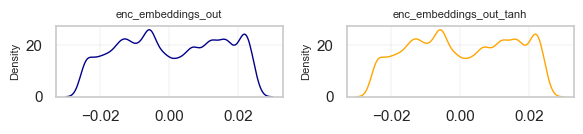

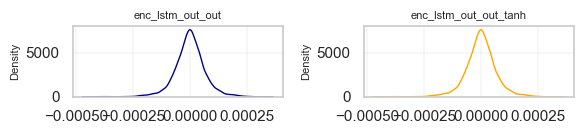

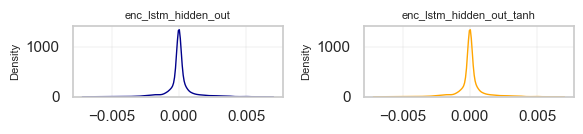

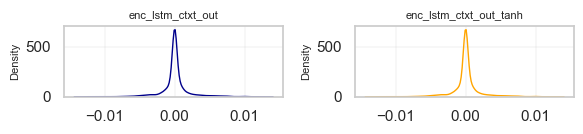

In [84]:
# plot
plot_network_layer("enc_embeddings", enc_emb_out, enc_emb_out_tanh, "tanh")
plot_network_layer("enc_lstm_out", enc_lstm_out, enc_lstm_out_tanh, "tanh")
plot_network_layer("enc_lstm_hidden", enc_lstm_hidden, enc_lstm_hidden_tanh, "tanh")
plot_network_layer("enc_lstm_ctxt", enc_lstm_ctxt, enc_lstm_ctxt_tanh, "tanh")

In [162]:
# decoder
class Decoder(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, lstm_layers: int, lstm_in_dim: int, lstm_hidden_dim: int):
        super().__init__()
    
        # embeddings
        tok_embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.tok_embeddings = init_xavier_uniform(tok_embeddings)

        # lstm
        lstm = nn.LSTM(
            input_size=lstm_in_dim,
            num_layers=lstm_layers,
            hidden_size=lstm_hidden_dim,
            batch_first=True,
            bidirectional=False
        )
        self.lstm = init_lstm_weights(lstm)
    
        # fc
        self.fc = nn.Linear(lstm_hidden_dim, vocab_size)

        # private
        self._lstm_in_ctxt_dim = lstm_in_dim - embedding_dim
        pass
    
    @staticmethod
    def _reshape_encoder_state(lstm_state: torch.Tensor):
        # reshape
        reshaped_state = lstm_state.view(
            lstm_state.shape[0] // 2, 2, 
            lstm_state.size(1), 
            lstm_state.size(2)
        )

        reshaped_state = reshaped_state.transpose(1, 2)

        # makes a copy with a memory layout of the tensor that is congruent with its shape.
        reshaped_state = reshaped_state.contiguous()
        
        reshaped_state = reshaped_state.view(
            lstm_state.size(0) // 2, 
            lstm_state.size(1), 
            lstm_state.size(2) * 2
        )

        return reshaped_state

    def forward(self, minibatch_source: torch.Tensor, minibatch_target: torch.Tensor, 
                enc_lstm_hidden: torch.Tensor, enc_lstm_ctxt: torch.Tensor, bos_tok_idx: int,
               use_teacher_forcing: bool = True):
        # batch size
        batch_size = enc_lstm_hidden.shape[1]
    
        # lstm hidden & ctxt
        lstm_hidden = self._reshape_encoder_state(enc_lstm_hidden)
        lstm_ctxt = self._reshape_encoder_state(enc_lstm_hidden)
        # @verify lstm_ctxt = self._reshape_encoder_state(enc_lstm_ctxt)
        
        # prediction ctxt
        enc_final_hidden_t = enc_lstm_hidden.transpose(0, 1)
        lstm_in_ctxt = enc_final_hidden_t.reshape(
            batch_size, 1, enc_final_hidden_t.shape[1] * enc_final_hidden_t.shape[2]
        ).contiguous()

        # start <bos>
        token_bos = lambda: torch.empty(batch_size, 1, dtype=torch.long).fill_(bos_token_idx)
        prev_token = token_bos()

        # time steps
        pred_steps = minibatch_target.shape[1]
        
        # decoder output
        decoder_outputs = list()
        
        for t in range(pred_steps):
            lstm_in = dec.tok_embeddings(prev_token) # updated
            # lstm_in_ctxt_t = lstm_in_ctxt.broadcast_to(batch_size, tok_emb.shape[1], self._lstm_in_ctxt_dim)
            # lstm_in = torch.cat((tok_emb, lstm_in_ctxt_t), dim=2)

            # lstm
            lstm_out, (lstm_hidden, lstm_ctxt) = self.lstm(lstm_in, (lstm_hidden, lstm_ctxt))
            lstm_out_tanh = torch.tanh(lstm_out)
            logits = dec.fc(lstm_out_tanh)
            
            # out
            decoder_outputs.append(logits)

            if use_teacher_forcing:
                prev_token = minibatch_target[:, t].unsqueeze(1)
            else:
                _, prev_token = logits.topk(1)
                prev_token = next_token.squeeze(-1).detach()
                pass

        decoder_outputs = torch.cat(decoder_outputs, dim=1)

        return decoder_outputs

In [166]:
# tok idx
bos_token_idx = 1

# configs
dec_embedding_dim = 128
dec_lstm_layers = enc_lstm_layers
dec_lstm_in_dim = dec_embedding_dim
# @previously dec_lstm_in_dim = enc_lstm_layers * (2 if enc_bidirec else 1) * enc_lstm_dim + dec_embedding_dim
dec_lstm_hidden_dim = 128 * (2 if enc_bidirec else 1)

# decoder
dec = Decoder(
    vocab_size=len(target_vocab.get_itos()),
    embedding_dim=dec_embedding_dim,
    lstm_layers=dec_lstm_layers,
    lstm_in_dim=dec_lstm_in_dim,
    lstm_hidden_dim=dec_lstm_hidden_dim
)

In [170]:
with torch.no_grad():
    # batch size
    batch_size = enc_lstm_hidden.shape[1]
    
    # lstm hidden & ctxt
    dec_lstm_hidden = dec._reshape_encoder_state(enc_lstm_hidden)
    dec_lstm_ctxt = dec._reshape_encoder_state(enc_lstm_ctxt)
    
    # prediction ctxt
    enc_final_hidden_t = enc_lstm_hidden.transpose(0, 1)
    dec_lstm_in_ctxt = enc_final_hidden_t.reshape(
        batch_size, 1, enc_final_hidden_t.shape[1] * enc_final_hidden_t.shape[2]
    ).contiguous()
    
    # start <bos>
    token_bos = lambda: torch.empty(batch_size, 1, dtype=torch.long).fill_(bos_token_idx)
    prev_token = token_bos().detach()
    pred_seq = token_bos().detach()
    
    # loss
    loss = None
    
    # times
    embedding_forward_times = list()
    lstm_forward_times = list()

    pred_steps = minibatch_target.shape[1]

    for t in range(pred_steps):
        embedding_start = time.perf_counter()
        dec_lstm_in = dec.tok_embeddings(prev_token) # updated
        
        # @verify dec_lstm_in_ctxt_t = dec_lstm_in_ctxt.broadcast_to(batch_size, dec_tok_emb.shape[1], dec_lstm_in_dim - dec_embedding_dim).contiguous()
        # @verify dec_lstm_in = torch.cat((dec_tok_emb, dec_lstm_in_ctxt_t), dim=2)

        # lstm
        lstm_start = time.perf_counter()
        embedding_time = lstm_start - embedding_start
        embedding_forward_times.append(embedding_time)
    
        dec_lstm_out, (dec_lstm_hidden, dec_lstm_ctxt) = dec.lstm(dec_lstm_in, (dec_lstm_hidden, dec_lstm_ctxt))
        dec_lstm_out_tanh = torch.tanh(dec_lstm_out)
        dec_logits = dec.fc(dec_lstm_out_tanh)  

        lstm_time = time.perf_counter() - lstm_start
        lstm_forward_times.append(lstm_time)
    
        # predict
        _, next_token = dec_logits.topk(1)
        next_token = next_token.squeeze(-1).detach()

        # update the predicted sequence
        pred_seq = torch.cat((pred_seq, next_token), dim=1)

        # teacher forcing
        prev_token = minibatch_target[:, t].unsqueeze(1).detach()
        pass

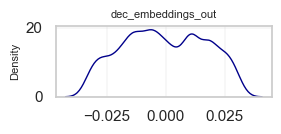

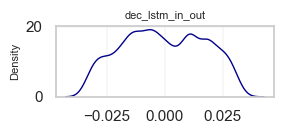

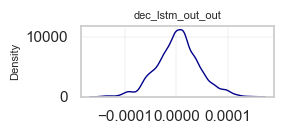

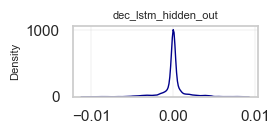

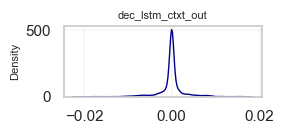

In [171]:
plot_network_layer("dec_embeddings", dec_tok_emb)
plot_network_layer("dec_lstm_in", dec_lstm_in)
plot_network_layer("dec_lstm_out", dec_lstm_out)
plot_network_layer("dec_lstm_hidden", dec_lstm_hidden)
plot_network_layer("dec_lstm_ctxt", dec_lstm_ctxt)

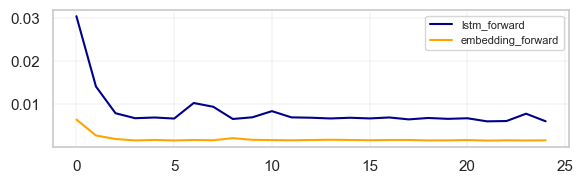

In [172]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
sns.set_context("notebook", rc={
    "grid.linewidth": 0.2, 
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "legend.fontsize": 8
})

sns.lineplot(lstm_forward_times, label="lstm_forward", color="darkblue")
sns.lineplot(embedding_forward_times, label="embedding_forward", color="orange")
plt.tight_layout()
plt.legend()
plt.show()

In [173]:
torch.enable_grad()
bos_tok_idx = source_vocab[Constants.SPECIAL_TOKEN_BOS]
train_loss_i = list()

In [174]:
train_loader, (source_vocab, target_vocab) = dataset.load("train", 256, current_device)

In [285]:
# opt
enc_opt = torch.optim.AdamW(enc.parameters(), lr = 3e-4)
dec_opt = torch.optim.AdamW(dec.parameters(), lr = 3e-4)
loss_function = nn.NLLLoss()

In [ ]:
# train
for e in range(100):
    print(f"*** epoch {e} ***")
    for i, batch in enumerate(train_loader):     
        b_source, b_target = batch
        
        lstm_hidden, lstm_ctxt = enc(b_source)
        decoded = dec(b_source, b_target, lstm_hidden, lstm_ctxt, bos_tok_idx)
        softmax = F.log_softmax(decoded, dim=-1)

        # zero grads
        enc.zero_grad(set_to_none=True)
        dec.zero_grad(set_to_none=True)
    
        # loss
        loss = loss_function(
            softmax.view(-1, softmax.size(-1)),
            b_target.view(-1)
        )

        # backprop
        loss.backward()
        enc_opt.step()
        dec_opt.step()

        # track
        train_loss_i.append(round(loss.item(), 2))

        if i % 10 == 0:
            print(np.mean(train_loss_i[-5:]))
            pass

In [ ]:
# plot
plt.plot(train_loss_i)

In [275]:
def run_inference(b_source_i, b_target_i):
    # eval
    enc.eval()
    dec.eval()

    with torch.no_grad():
        source_words = []
        for tok_idx in b_source[inf_idx].squeeze().tolist():
            source_words.append(source_vocab.get_itos()[tok_idx])
            pass
        
        print("source: ", " ".join(source_words))

        source_str = b_source_i.unsqueeze(0)
        target_str = b_target_i.unsqueeze(0)

        lstm_hidden, lstm_ctxt = enc(source_str)
        decoded = dec(source_str, target_str, lstm_hidden, lstm_ctxt, bos_tok_idx, teacher_forcing=False)

        _, pred_seq = decoded.topk(1)
        decoded_toks = pred_seq.squeeze().tolist()

        decoded_words = []
        for tok_idx in decoded_toks:
            decoded_words.append(target_vocab.get_itos()[tok_idx])
            pass

        print("target: ", " ".join(decoded_words), "\n")
        pass
    
    # train
    enc.train()
    dec.train()
    pass

In [292]:
inf_idx = 5
run_inference(b_source[inf_idx], b_target[inf_idx])

source:  <bos> Eine ältere Frau mit einem Taschentuch und einem Stock steht auf einer matschigen gepflasterten Straße . 
 <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
target:  <bos> A man man is a white is a shirt is on a street . and . 
 <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

